# SVM. Метод опорных векторов + Кросс-валидация

В этом задании вы попрактикуетесь в применении метода опорных векторов, а также примените кросс-валидацию для подбора гиперпараметров и оценки качества моделей!

## Данные

В этой практической работе мы будем обучать модели машинного обучения, ставить эксперименты, подбирать гиперпараметры и сравнивать модели. Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - `age`
 - `workclass`
 - `fnlwgt`
 - `education`
 - `education-num`
 - `marital-status`
 - `occupation`
 - `relationship`
 - `race`
 - `sex`
 - `capital-gain`
 - `capital-loss`
 - `hours-per-week`

Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

## Бонус ноутбука

Все исследователи данных знают, что SVM из библиотеки `sklearn` работает крайне медленно, поэтому на практике не могут его применять для решения задач.

В этом ноутбуке мы используем средства библиотеки `sklearn intelex` для ускорения обучения SVM в 600 раз!

Ради интереса попробуйте после завершения выполнения заданий в ноутбуке удалить ячейки, связанные с установкой и импортом `sklearn intelex` и засечь время работы методов :)

In [ ]:
# убедимся, что версия python < 3.10
!python --version

Python 3.10.12


In [ ]:
%%capture
!python -m pip install --upgrade pip
!pip install --upgrade scikit-learn-intelex

In [ ]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [1]:
import pandas as pd
import numpy as np
import sys
import os
import site

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from matplotlib import pyplot as plt

sys.path.append(os.path.join(os.path.dirname(site.getsitepackages()[0]), "site-packages"))

## Метрика качества

В задании мы будем оценивать качество моделей с помощью метрики *AUC-ROC*.

Загрузим набор данных `data.adult.csv`.

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/data.adult.csv")

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K


Иногда в данных встречаются пропуски. Как задаются пропуски обычно либо прописывается в описании к данным, либо просто на месте пропуска после чтения данных оказывается значение `numpy.nan`.  
Более подробно о работе с пропусками в Pandas можно прочитать например [здесь](http://pandas.pydata.org/pandas-docs/stable/missing_data.html).

В данном датасете пропущенные значения обозначены как "?".

### Задание

Найдите все признаки, имеющие пропущенные значения.

Затем удалите из выборки все объекты с пропусками.

In [3]:
for c in df.columns:
    print(c, len(df[df[c] == '?']))

age 0
workclass 929
fnlwgt 0
education 0
education-num 0
marital-status 0
occupation 933
relationship 0
race 0
sex 0
capital-gain 0
capital-loss 0
hours-per-week 0
>50K,<=50K 0


In [4]:
# your code here
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16280 entries, 0 to 16279
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             16280 non-null  int64 
 1   workclass       16280 non-null  object
 2   fnlwgt          16280 non-null  int64 
 3   education       16280 non-null  object
 4   education-num   16280 non-null  int64 
 5   marital-status  16280 non-null  object
 6   occupation      16280 non-null  object
 7   relationship    16280 non-null  object
 8   race            16280 non-null  object
 9   sex             16280 non-null  object
 10  capital-gain    16280 non-null  int64 
 11  capital-loss    16280 non-null  int64 
 12  hours-per-week  16280 non-null  int64 
 13  >50K,<=50K      16280 non-null  object
dtypes: int64(6), object(8)
memory usage: 1.7+ MB


In [5]:
df.shape

(16280, 14)

In [6]:
# your code here

df = df.replace('?', pd.NA)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16280 entries, 0 to 16279
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             16280 non-null  int64 
 1   workclass       15351 non-null  object
 2   fnlwgt          16280 non-null  int64 
 3   education       16280 non-null  object
 4   education-num   16280 non-null  int64 
 5   marital-status  16280 non-null  object
 6   occupation      15347 non-null  object
 7   relationship    16280 non-null  object
 8   race            16280 non-null  object
 9   sex             16280 non-null  object
 10  capital-gain    16280 non-null  int64 
 11  capital-loss    16280 non-null  int64 
 12  hours-per-week  16280 non-null  int64 
 13  >50K,<=50K      16280 non-null  object
dtypes: int64(6), object(8)
memory usage: 1.7+ MB


In [8]:
# отсутствуют где-то 5%. удалять так удалять.

df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15347 entries, 0 to 16279
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             15347 non-null  int64 
 1   workclass       15347 non-null  object
 2   fnlwgt          15347 non-null  int64 
 3   education       15347 non-null  object
 4   education-num   15347 non-null  int64 
 5   marital-status  15347 non-null  object
 6   occupation      15347 non-null  object
 7   relationship    15347 non-null  object
 8   race            15347 non-null  object
 9   sex             15347 non-null  object
 10  capital-gain    15347 non-null  int64 
 11  capital-loss    15347 non-null  int64 
 12  hours-per-week  15347 non-null  int64 
 13  >50K,<=50K      15347 non-null  object
dtypes: int64(6), object(8)
memory usage: 1.8+ MB


Обычно после загрузки датасета всегда необходима его некоторая предобработка.  
В данном случае она будет заключаться в следующем:

 - Выделите целевую переменную y в отдельную переменную и преобразуйте к бинарному формату по правилу:  
 '>50K' - 1, '<=50K' - 0.
 - Выделите матрицу объект-признак `X`, содержащую только вещественные столбцы (числовые) и не содержащую целевой переменной
 - Обратите внимание, что не все признаки являются вещественными. В начале мы будем работать только с вещественными признаками. Выделите их отдельно.

In [9]:
# your code here
y = df['>50K,<=50K'].apply(lambda x: 1 if x == '>50K' else 0)
y.head()

,">50K,<=50K"
0,0
1,0
2,0
3,0
4,1


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15347 entries, 0 to 16279
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             15347 non-null  int64 
 1   workclass       15347 non-null  object
 2   fnlwgt          15347 non-null  int64 
 3   education       15347 non-null  object
 4   education-num   15347 non-null  int64 
 5   marital-status  15347 non-null  object
 6   occupation      15347 non-null  object
 7   relationship    15347 non-null  object
 8   race            15347 non-null  object
 9   sex             15347 non-null  object
 10  capital-gain    15347 non-null  int64 
 11  capital-loss    15347 non-null  int64 
 12  hours-per-week  15347 non-null  int64 
 13  >50K,<=50K      15347 non-null  object
dtypes: int64(6), object(8)
memory usage: 1.8+ MB


In [11]:

X = df[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']].copy()
X.shape

(15347, 6)

### Задание

Cколько столбцов содержит матрица `X`?

Постройте гистограммы для признаков `age`, `fnlwgt`, `capital-gain`. Глядя на получившиеся графики в чем заключается особенность данных? На какие алгоритмы это может повлиять? Может ли масшитабирование повлиять на работу этих алгоритмов?

Ответьте на этот вопрос для себя устно.

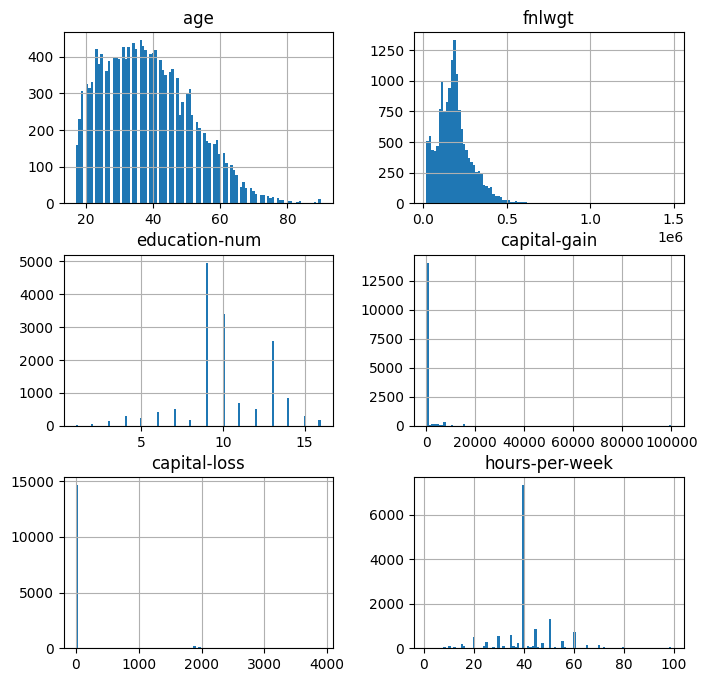

In [12]:
# your code here
X.hist(bins=100, figsize=(8,8));

In [13]:
import seaborn as sns

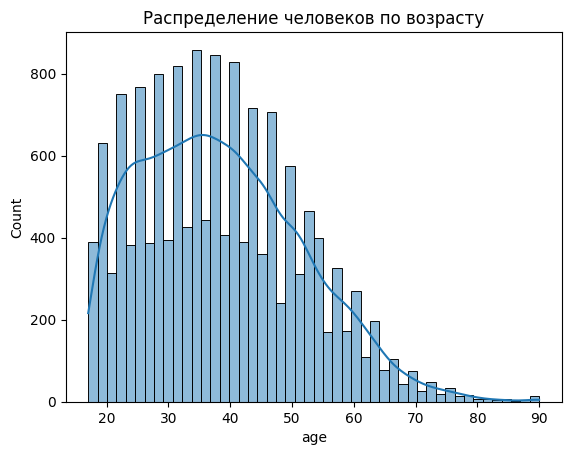

In [14]:
#распределение по возрасту
sns.histplot(df['age'], kde=True)
plt.title('Распределение человеков по возрасту')
plt.show()

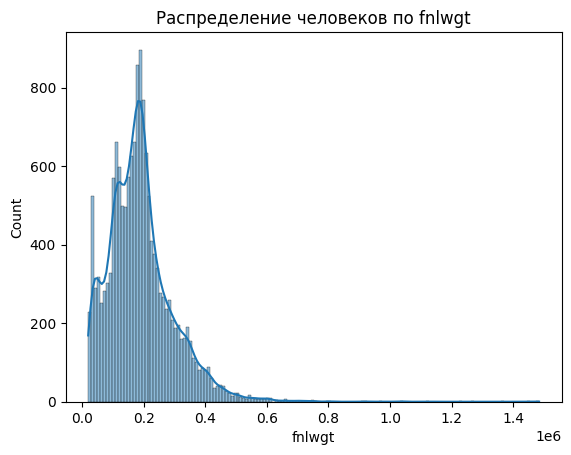

In [15]:
#распределение по ...
sns.histplot(df['fnlwgt'], kde=True)
plt.title('Распределение человеков по fnlwgt')
plt.show()

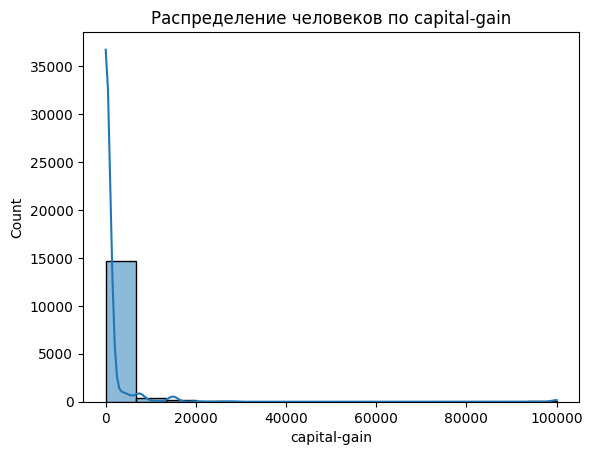

In [16]:
#распределение по ...
sns.histplot(df['capital-gain'], kde=True)
plt.title('Распределение человеков по capital-gain')
plt.show()

Масштабируйте все вещественные признаки (масштабированную матрицу назовите, как и раньше, `X`).

In [17]:
from sklearn.preprocessing import StandardScaler

# your code here

ss = StandardScaler()
X = pd.DataFrame(ss.fit_transform(X,y), columns=X.columns)

## Обучение классификаторов на вещественных признаках

В данном разделе необходимо будет работать только с вещественными признаками и целевой переменной.

В этом задании необходимо проверять качество алгоритмов по кросс-валидации. Напомним, что это за процесс.


### Кросс-валидация [обучающий текст]

Разбивать данные на train-test как мы делали раньше - неплохой подход. Однако при этом подходе мы привязываем и обучение модели, и оценку качества к конкретному разбиению, а для другого разбиения можем получить модель совершенно другого качества, что плохо.

Поэтому хочется оценить качество модели без привязки к конкретному разбиению на train-test. Для этого все обучающие данные разбиваются на несколько равных блоков (фолдов), и затем модель обучается несколько раз:
* первый раз - на всех блоках, кроме 1-го, а качество оценивается на 1-м блоке
* второй раз - на всех блоках, кроме 2-го, а качество оценивается на 2-м блоке и так далее
Для оценки качества модели полученные значения метрик на тестовых блоках усредняются - это называется *k-fold кросс-валидацией*.

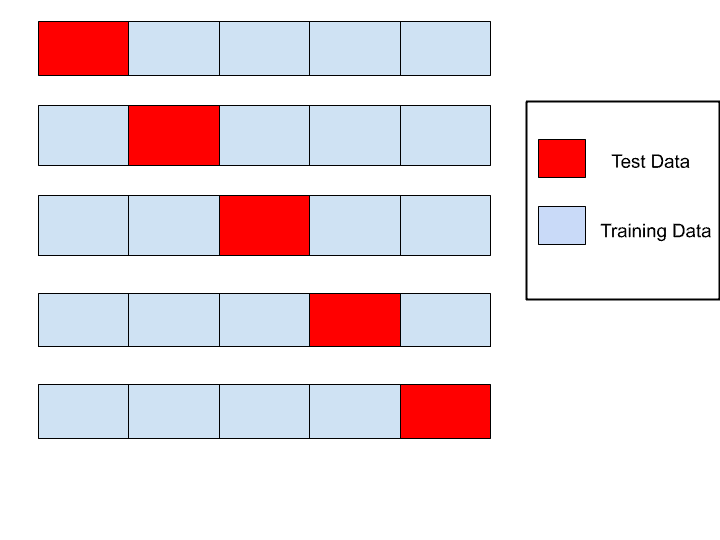

Сначала обучите по кросс-валидации c **тремя** фолдами и метрикой **roc_auc** алгоритмы:
*  LogisticRegression
*  SVC(kernel='linear')

Остальные параметры оставьте по умолчанию.

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

# пример для логистической регрессии

cross_val_score(LogisticRegression(), X, y, cv=3, scoring='roc_auc', verbose=2).mean()

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.1s


0.8250515880497281

In [19]:
# посмотрите на среднее качество SVM с линейным ядром

# your code here
cross_val_score(SVC(kernel='linear'), X, y, cv=3, scoring='roc_auc', verbose=2).mean()

[CV] END .................................................... total time=   7.7s
[CV] END .................................................... total time=   6.9s
[CV] END .................................................... total time=   5.6s


0.8100354760945175

### Задание

Чему равно качество наилучшей из этих моделей?  
Ответ округлите до десятых.

In [20]:
round(0.82502,1)

0.8

Теперь посмотрим как влияет подбор гиперпараметров на качество предсказания моделей. Сейчас и далее будем рассматривать два алгоритма:
 - Logistic Regression
 - SVC (Support Vector Classifier)

У обоих алгоритмов будем оптимизировать гиперпараметр С, а у SVC - ещё гиперпараметр kernel.

*  Ищите C в диапазоне от 0.01 до 10.01 с шагом 0.25
*  Перебирайте ядра из списка ['rbf','poly','sigmoid','linear']

### Подбор гиперпараметров по сетке (GridSearchCV) [обучающий текст]

Раз уж мы начали использовать кросс-валидацию, то будем использовать ее по-максимуму. Для подбора гиперпараметров модели также можно применить этот подход вместо разбиения на train и test.

Идея подбора гиперпараметров по сетке:

* задаем список перебираемых значений гиперпараметров (можно подбирать одновременно несколько гиперпараметров)

* для каждого набора значений гиперпараметров вычисляем качество модели по кросс-валидации

* итоговый ответ - это набор значений гиперпараметров, для которого модель имеет наибольшее качество на кросс-валидации.

Метод, реализующий эту схему, называется GridSearchCV.

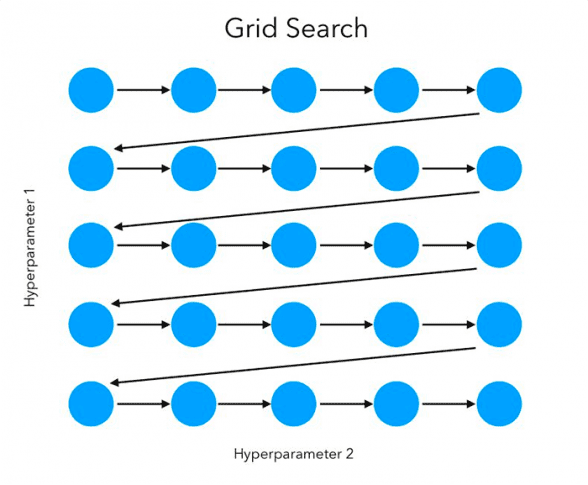

Для подбора гиперпараметров воспользуйтесь перебором по сетке, который реализован в классе GridSearchCV. В качестве схемы кросс-валидации используйте 3-fold cv.

Покажем пример использования GridSearchCV.

In [ ]:
# подберите C у логистической регрессии

from sklearn.model_selection import GridSearchCV

params = {'C' : [1, 2, 3]} # задаем словарь параметров и список перебираемых значений - в данном случае ищем C из списка [1,2,3]

gs = GridSearchCV(LogisticRegression(), params, cv=3, scoring='roc_auc')
# первый параметр - модель, второй - словарь параметров, третий - число фолдов, четвертый - метрика

gs.fit(X, y) # применяем метод к данным X, y (GridSearchCV сам разобъет данные на фолды)

print(gs.best_score_) # качество наилучшей модели (с оптимальными гиперпараметрами)
print(gs.best_params_) # оптимальные гиперпараметры

0.825026286490548
{'C': 1}


In [ ]:
# your code here

params = {'C' :list(np.arange(0.01, 10, 0.25)) } # задаем словарь параметров и список перебираемых значений - в данном случае ищем C из списка [0.01,...,10]

gs = GridSearchCV(LogisticRegression(), params, cv=3, scoring='roc_auc')

gs.fit(X, y) # применяем метод к данным X, y (GridSearchCV сам разобъет данные на фолды)

print(gs.best_score_) # качество наилучшей модели (с оптимальными гиперпараметрами)
print(gs.best_params_) # оптимальные гиперпараметры


0.825026887359309
{'C': 0.01}


In [ ]:
# так как SVM работает долго, то:
# сначала первым gridsearch подберите у метода только kernel
# вторым gridsearch для найденного ядра подберите C в диапазане от 0.01 до 2.01 с шагом 0.25

# your code here
params = {'C' :list(np.arange(0.01, 2.01, 0.25)) }

kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kern in kernels:

  gs = GridSearchCV(SVC(kernel=kern), params, cv=3, scoring='roc_auc')
  gs.fit(X, y) # применяем метод к данным X, y (GridSearchCV сам разобъет данные на фолды)
  print(kern)
  print(gs.best_score_) # качество наилучшей модели (с оптимальными гиперпараметрами)
  print(gs.best_params_) # оптимальные гиперпараметры

linear
0.8117275580911004
{'C': 0.01}
poly
0.8085960889945785
{'C': 0.01}
rbf
0.8144653639974792
{'C': 0.01}
sigmoid
0.7994566622382155
{'C': 0.01}


### Задание

Какой из алгоритмов имеет наилучшее качество?

Сравните алгоритмы с точки зрения времени обучения. Обучение какого из алгоритмов работает дольше всего и, как вы думаете, почему?

## Добавление категориальных признаков в модели

Пока мы не использовали нечисловые признаки, которые есть в датасете. Давайте посмотрим, правильно ли мы сделали и увеличится ли качество моделей после добавлениях этих признаков.

*  Преобразуйте все категориальные признаки (исходной матрицы df) с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [`pandas.get_dummies`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html). Чтобы избежать переобучения, в `get_dummies` поставьте гиперпараметр **`drop_first=True`**.

*  Заново масштабируйте данные

In [21]:
X_old = df.drop('>50K,<=50K', axis=1)

X_old.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15347 entries, 0 to 16279
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             15347 non-null  int64 
 1   workclass       15347 non-null  object
 2   fnlwgt          15347 non-null  int64 
 3   education       15347 non-null  object
 4   education-num   15347 non-null  int64 
 5   marital-status  15347 non-null  object
 6   occupation      15347 non-null  object
 7   relationship    15347 non-null  object
 8   race            15347 non-null  object
 9   sex             15347 non-null  object
 10  capital-gain    15347 non-null  int64 
 11  capital-loss    15347 non-null  int64 
 12  hours-per-week  15347 non-null  int64 
dtypes: int64(6), object(7)
memory usage: 1.6+ MB


In [22]:
columns = ['workclass', 'race', 'education', 'marital-status', 'occupation', 'relationship', 'sex' ]
X_new = pd.get_dummies(X_old, columns=columns, drop_first=True) # your code here
X_new.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,sex_Male
0,34,284843,9,594,0,60,True,False,False,False,...,False,False,False,False,True,False,False,False,False,True
1,40,190290,10,0,0,40,False,True,False,False,...,False,True,False,False,True,False,False,False,False,True
2,36,177858,13,0,0,40,True,False,False,False,...,False,False,False,False,False,False,True,False,False,True
3,22,184756,10,0,0,30,False,True,False,False,...,False,True,False,False,False,False,True,False,False,False
4,47,149700,13,15024,0,40,False,True,False,False,...,False,False,True,False,False,False,False,False,False,True


Так как после кодирования признаков получилось достаточно много, в этой работе мы не будем добавлять их и подбирать заново оптимальные гиперпараметры.

Обучите алгоритмы с наилучшими гиперпараметрами из предыдущего пункта. Дало ли добавление новых признаков прирост качества? Измеряйте качество как и раньше используя 3-Fold CV в функции `cross_val_score`.

In [ ]:
#from sklearn.model_selection import cross_val_score
#from sklearn.metrics import roc_auc_score

#from sklearn.svm import SVC

cross_val_score(SVC(kernel = 'linear', C=0.01), X_new, y, cv=3, scoring='roc_auc', verbose=2).mean()


In [22]:
#your code here
cross_val_score(LogisticRegression(C=0.01), X_new, y, cv=3, scoring='roc_auc', verbose=2).mean()

[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s


0.580242543707173

Отличается ли теперь наилучший классификатор от наилучшего в предыдущем пункте?

### Задание

*  Разбейте данные на тренировочную и тестовую часть (либо данные только с числовыми признаками, либо данные после OneHot-кодировки - в зависимости от того, на каких данных модели лучше отработали).

**Вопрос:**  
стали ли модели лучше решать задачу при добавлении закодированных категориальных признаков?

*test_size = 0.25, random_state = 42*

* Cреди всех обученных в работе моделей возьмите наилучшую (по roc-auc).
Заново обучите эту модель на тренировочных данных, сделайте предсказание на тесте.

* Постройте roc-кривую и отметьте на ней значение roc-auc - по тестовым данным.

In [23]:
from sklearn.model_selection import train_test_split

#your code here
Xtrain, Xtest, ytrain, ytest = train_test_split(X_new, y, test_size=0.25, random_state=42)

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(Xtrain)
Xtrain = pd.DataFrame(scaler.transform(Xtrain), columns=X_new.columns)
Xtest = pd.DataFrame(scaler.transform(Xtest), columns=X_new.columns)

In [25]:
from sklearn.svm import SVC
model = SVC(kernel='linear', probability=True)
model.fit(Xtrain, ytrain)
pred = model.predict(Xtest)

In [26]:
from sklearn.metrics import roc_curve, auc

#your code here
pred = model.predict_proba(Xtest)[:,1]
roc_auc_score(ytest, pred)
print(pred)

[0.0798992  0.03375518 0.7717006  ... 0.22138387 0.03110049 0.01535669]


In [27]:
print(roc_auc_score)

<function roc_auc_score at 0x7c220d06b520>


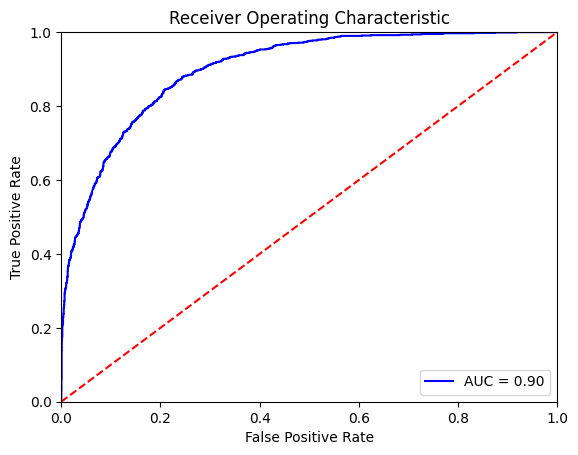

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(ytest, pred)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

### Задание

Чему равен `roc-auc` наилучшей модели на тестовых данных?